In [1]:
import sys
from datasets import load_dataset
from loguru import logger

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/vtikz", "tikz", split="benchmark")
ds = ds.select_columns(["id","type","instruction","code","template_solution_code"])


/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Utils

In [2]:
from datasets.formatting.formatting import LazyBatch
from collections import defaultdict
from notebooks.verifier_ds_creation.verifier_utils import (
    generate_all_incorrect_solutions,
    get_default,
    handle_def,
)


def create_incorrect_solutions(row: LazyBatch):
    all_created_template_codes: dict[str : list[str]] = defaultdict(list)
    original_code = row["code"][0]
    ignored_row = []
    for template_code in row["template_solution_code"][0]:
        all_created_template_codes[template_code], ignored = (
            generate_all_incorrect_solutions(original_code, template_code)
        )
        ignored_row.append(ignored)

    if all(ignored_row):
        logger.warning(f"{row['id']} is ignored.")

    new_rows = defaultdict(list)
    for template, created_template_codes in all_created_template_codes.items():
        for created_template_code in created_template_codes:
            for existing_col in set(row.keys()):
                new_rows[existing_col].append(row[existing_col][0])
            new_rows["original_template"].append(template)
            new_rows["solution"].append(created_template_code)
            new_rows["expected"].append(False)
    if len(new_rows) == 0:
        new_rows = {
            "original_template": [],
            "solution": [],
            "expected": [],
        }
        for existing_col in set(row.keys()):
            new_rows[existing_col] = []
    return new_rows


def create_default_solution(row: LazyBatch):
    default_codes: dict[str, str] = {}
    for template_code in row["template_solution_code"][0]:
        default_codes[template_code] = get_default(handle_def(template_code)[0])
    new_rows = defaultdict(list)
    for template, created_default_code in default_codes.items():
        for existing_col in set(row.keys()):
            new_rows[existing_col].append(row[existing_col][0])
        new_rows["original_template"].append(template)
        new_rows["solution"].append(created_default_code)
        new_rows["expected"].append(True)


### Creating the dataset + filtering

In [3]:

#test_ds = Dataset.from_dict({"template_solution_code":[[test_code]]})
selected = 96
test_ds  = ds.select([selected])
print(ds[selected]["id"])
test_expanded_ds = test_ds.map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)

Parameter 'function'=<function create_incorrect_solutions at 0x7eaccac05260> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


vr_two_motors


Map: 100%|██████████| 1/1 [00:28<00:00, 28.86s/ examples]


In [4]:
expanded_ds_cor = ds.map(create_default_solution,batched=True,batch_size=1,load_from_cache_file=False)


Map: 100%|██████████| 100/100 [00:00<00:00, 5529.15 examples/s]


In [ ]:
expanded_ds_inc = ds.select(range(len(ds) - 1, -1, -1)).map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)

Map:   2%|▏         | 2/100 [01:40<1:24:14, 51.58s/ examples]

In [ ]:
from datasets import Dataset,concatenate_datasets
generated_ds:Dataset = concatenate_datasets([expanded_ds_cor,expanded_ds_inc])

In [ ]:
len(generated_ds)

5491

#### Filtering the ones that do not compile

In [7]:
import sys
from vif.utils.renderer.tex_renderer import TexRenderer


renderer = TexRenderer()

def renders(row):
    try:
        renderer.from_string_to_image(row["solution"])
        row["compiles"]=True
    except:
        row["compiles"]=False
    return row

In [8]:
compiling_generated = generated_ds.map(renders)

Map: 100%|██████████| 5491/5491 [41:37<00:00,  2.20 examples/s]  


In [9]:
compiling_generated_pd = compiling_generated.to_pandas()
compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==True]
not_compiling_generated_filtered = compiling_generated_pd[compiling_generated_pd["compiles"]==False]

In [ ]:
print(len(not_compiling_generated_filtered))
    

4112
\documentclass[tikz,border=5]{standalone}
\usepackage[prefix=]{xcolor-material}

\tikzset{
  half clip/.code={
    \clip (0, -256) rectangle (256, 256);
  },
  color alias/.code args={#1 as #2}{\colorlet{#1}{#2}},
  colors alias/.style={color alias/.list/.expanded={#1}},
  execute/.code={#1},
  on left/.style={.. on left/.style={#1}},
  on right/.style={.. on right/.style={#1}},
}
\newcommand\reflect[2][]{
\begin{scope}[#1]\foreach \side in {-1, 1}{\begin{scope}
\ifnum\side=-1 \tikzset{.. on left/.try}\else\tikzset{.. on right/.try}\fi
\begin{scope}[xscale=\side]#2\end{scope}
\end{scope}}\end{scope}}


\tikzset{
bee/.pic={
\begin{scope}[x=3cm/480,y=3cm/480, rotate=-45, shift=(270:48)]
\reflect[
  on left= {colors alias={body as BlueGrey800, stripes as Amber500}},
  on right={colors alias={body as BlueGrey900, stripes as Amber700}, half clip},
  lower wing/.style={fill=BlueGrey100}, upper wing/.style={fill=BlueGrey50}]{
  \fill [body] (0,-160)
    .. controls ++(120:64) and ++(270:

#### Removing duplicate ones(If Any)

In [11]:
compiling_dedup_pd = compiling_generated_filtered.drop_duplicates("solution")

In [12]:
print(len(generated_ds))
print(len(compiling_generated))
print(len(compiling_dedup_pd))

5491
5491
1379


#### Creating a 50/50 ratio

In [31]:
import pandas as pd
def balance_group(g):
    n = min(g['expected'].sum(), (~g['expected']).sum())
    return pd.concat([
        g[g['expected']].head(n),
        g[~g['expected']].head(n)
    ])

dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)

/tmp/ipykernel_203149/4119551737.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dedup_50 = compiling_dedup_pd.groupby("id", group_keys=False).apply(balance_group).reset_index(drop=True)


#### Publishing the raw dataset

In [35]:
#we'll see later about that
pds_dedup = Dataset.from_pandas(dedup_50)
pds_dedup.push_to_hub("CharlyR/VeriTikz", config_name="raw", split="train")

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/7be6f342d54cc22b6429ad0f9217838adad16556', commit_message='Upload dataset', commit_description='', oid='7be6f342d54cc22b6429ad0f9217838adad16556', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

#### Dataset statistics

In [33]:
pd.set_option('display.max_rows', None)

dedup_50[["id","expected"]].groupby("id").value_counts().unstack(fill_value=0).describe()

expected,False,True
count,81.000000,81.000000
mean,3.160494,3.160494
std,2.943029,2.943029
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,4.000000,4.000000
max,14.000000,14.000000


#### Adding the image to the dataset

In [10]:
import sys
from datasets import load_dataset,Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "raw", split="train")

renderer = TexRenderer()

def add_or_cust_image(row):
    row["original_image"] = renderer.from_string_to_image(row["code"])
    row["solution_image"] = renderer.from_string_to_image(row["solution"])
    return row




In [11]:
updated_ds = veritikz_dataset.map(add_or_cust_image,num_proc=5)
updated_ds = updated_ds.remove_columns("compiles")

Map (num_proc=5): 100%|██████████| 512/512 [02:13<00:00,  3.85 examples/s]


In [12]:
updated_ds.push_to_hub("CharlyR/VeriTikz", config_name="full", split="train")


Uploading the dataset shards: 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/CharlyR/VeriTikz/commit/3a2050874a033299b1adeaa03ac2d4b1af8931b9', commit_message='Upload dataset', commit_description='', oid='3a2050874a033299b1adeaa03ac2d4b1af8931b9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/CharlyR/VeriTikz', endpoint='https://huggingface.co', repo_type='dataset', repo_id='CharlyR/VeriTikz'), pr_revision=None, pr_num=None)

### Manual Exploration

In [1]:
import sys
from datasets import load_dataset,Dataset
from loguru import logger
from vif.utils.renderer.tex_renderer import TexRenderer

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
veritikz_dataset = load_dataset("CharlyR/VeriTikz", "full", split="train")
i=0

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Make the horns of the cow longer
True


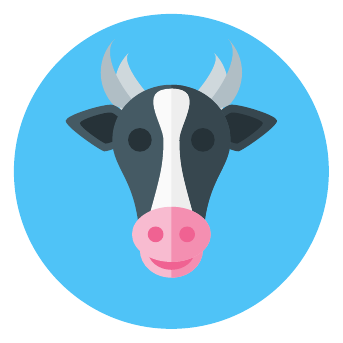

In [145]:
row = veritikz_dataset[i]
print(row["instruction"])
print(row["expected"])
open("notebooks/verifier_ds_creation/code.tex","w").write(row["solution"])
open("notebooks/verifier_ds_creation/originalcode.tex","w").write(row["original_template"])
display(row["solution_image"])
i+=1 

In [146]:
i

365

In [143]:
i=240

### some tests

In [1]:
from notebooks.verifier_ds_creation.invalid_variant_creation import apply_random_modifications


failing_code = open(".oui/original copy.tex").read()
apply_random_modifications(failing_code,1,1,3)

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-30 11:20:52.859 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:45 - latex renderer writing to /home/creux/.cache/varbench/890381ce-7c6f-4aac-9aab-d5f02f1bd830.tex
2025-10-30 11:20:53.319 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:78 - converting /home/creux/.cache/varbench/890381ce-7c6f-4aac-9aab-d5f02f1bd830.tex to png
2025-10-30 11:20:53.343 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:45 - latex renderer writing to /home/creux/.cache/varbench/e009dedc-df7c-4264-ba24-8b54091481f5.tex
2025-10-30 11:20:53.797 | DEBUG    | vif.utils.renderer.tex_renderer:from_string_to_image:78 - converting /home/creux/.cache/varbench/e009dedc-df7c-4264-ba24-8b5409

['\\documentclass[tikz,border=5]{standalone}\n\\usepackage[prefix=]{xcolor-material}\n\n\\tikzset{\nchimpanzee/.pic={\n\\tikzset{x=3cm/3.5,y=3cm/3.5, shift={(0,1/7)}}\n\\fill [BlueGrey700] (165:5/4 and 1) ellipse [radius=1/2];\n\\fill [Pink100]     (165:5/4 and 1) ellipse [radius=1/3];\n\\fill [BlueGrey700]\n  (0,-1/2) ellipse [x radius=1, y radius=4/3]\n  (0,   0) ellipse [x radius=4/3, y radius=1];\n\\scoped{\n  \\clip(0,-2) rectangle(9/5,1);\n  \\fill [BlueGrey900] (15:5/4 and 1) ellipse [radius=1/2];\n  \\fill [Pink200]     (15:5/4 and 1) ellipse [radius=1/3];\n  \\fill [BlueGrey900]\n    (0,-1/2) ellipse [x radius=1, y radius=4/3]\n    (0,   0) ellipse [x radius=4/3, y radius=1];\n}\n\\fill [Pink100]            (  0,-2/3) ellipse [x radius=5/6, y radius=  1];\n\\fill [Pink100, xscale=-1] (1/2,   0) ellipse [x radius=3/5, y radius=2/3];\n\\fill [Pink100, xscale= 1] (1/2,   0) ellipse [x radius=3/5, y radius=2/3];\n\\scoped{\n  \\clip(0,-2) rectangle(9/5,1);\n  \\fill [Pink200]     

In [2]:
test_row_code = ds.select([24])["template_solution_code"][0][0]
original_test_row_code = ds.select([25])["code"][0]
original_test_row_code

'\\documentclass[tikz,border=5]{standalone}\n\\usepackage{tikz}\n\\usetikzlibrary{\n                arrows.meta,\n                bending,\n                positioning\n               }\n\\tikzset{\n         > = Latex,\n         arrows = {[bend]},\n         signal/.style = coordinate,\n         sum/.style = {\n                       draw,\n                       circle,\n                       minimum size = 2mm\n                      },\n         block/.style = {\n                         draw,\n                         rectangle,\n                         minimum height = 2em,\n                         minimum width = 4em\n                        },\n         branch/.style = {\n                          sum,\n                          minimum size = 1mm,\n                          fill = black\n                         }\n        }\n\n\\begin{document}\n\n  \\begin{tikzpicture}[auto]\n\n    \\node[signal] (input) {};\n    \\node[sum, right = of input] (left sum) {};\n    \\node[block

In [ ]:
from notebooks.verifier_ds_creation.invalid_variant_creation import apply_random_modifications


new_code = apply_random_modifications(original_test_row_code)

In [5]:
from vif.utils.renderer.tex_renderer import TexRenderer


renderer = TexRenderer()
renderer.from_string_to_image(new_code)

TypeError: write() argument must be str, not tuple

In [ ]:
generate_all_incorrect_solutions(original_test_row_code,test_row_code)

In [ ]:
test_row = ds.select(range(24,100))
hu=test_row.map(create_incorrect_solutions,batched=True,batch_size=1,load_from_cache_file=False)


In [11]:
from notebooks.verifier_ds_creation.verifier_utils import all_incorrect_from_template


test_code="""

sq
§range(5,20,15)
qsdfqs
§rangei(25,5)
dsqqfqsdf
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)
Red§choice([50,100,200],100)

"""

all_incorrect_from_template(test_code)

['\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed800\nRed600\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed300\nRed100\nRed600\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n33\ndsqqfqsdf\nRed100\nRed100\nRed500\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed100\nRed900\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n25\ndsqqfqsdf\nRed600\nRed400\nRed100\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n17\ndsqqfqsdf\nRed100\nRed400\nRed100\nRed100\n\n',
 '\n\nsq\n0\nqsdfqs\n25\ndsqqfqsdf\nRed100\nRed900\nRed100\nRed100\n\n',
 '\n\nsq\n15\nqsdfqs\n33\ndsqqfqsdf\nRed500\nRed100\nRed100\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n25\ndsqqfqsdf\nRed800\nRed100\nRed100\nRed100\n\n',
 '\n\nsq\n24\nqsdfqs\n17\ndsqqfqsdf\nRed100\nRed100\nRed100\nRed100\n\n']

In [1]:

from notebooks.verifier_ds_creation.verifier_utils import create_arrangements


create_arrangements(5,-1,4)

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[1, 1, 1, 1, 0],
 [1, 1, 1, 0, 1],
 [1, 1, 0, 1, 1],
 [1, 0, 1, 1, 1],
 [0, 1, 1, 1, 1]]